# MNIST Dataset (First Part of Project)

In [1]:
pip install keras==2.6

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np 
import tensorflow
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
(train_set, train_label), (test_set, test_label) = mnist.load_data()
train_set, train_label = train_set[:20000], train_label[:20000]

In [4]:
train_set.shape

(20000, 28, 28)

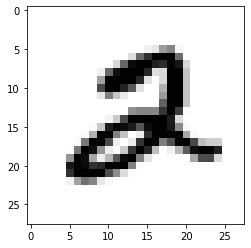

In [5]:
plt.imshow(train_set[5][:,:], cmap = plt.cm.binary)

In [6]:
#Reshape the images as a 784d vector
train_set = train_set.reshape(20000,-1)/255

In [7]:
#Binarising the data for use in Bernoulli 
train_set[train_set < 0.5] = 0
train_set[train_set > 0.5] = 1 

# Section 1. Implementing a Multi Dimensional Bernoulli random variable

Approach here is to treat each image as a vector of dimension 784. Since we normalised the image, each pixel in the image will be in the range [0,1]

Assume that for a given image vector $X_i$, it has pixels $$X_i = [x_{i1}, x_{i2}, x_{i3}, .... , x_{id}]$$Our bernoulli random variable follows the distribution $$p(x_j | \theta_j) = \theta_j^{x_j} (1 - \theta_j)^{1 - x_j}$$So for each pixel belonging to $X_i$, it follows the above distribution. The main assumption again that we follow is that the pixels in a given image are independent of each other. So by the rule of independence, we have $$\begin{equation}
p(X_i | \theta) = \Pi_{j=1}^d p(x_{ij} | \theta_j)
\end{equation}$$



Now that we know the probability distribution for a single image, we compute the total data likelihood which is the product of the above distribution for each image i.e. $$\begin{equation} p(D| \theta) = \Pi_{i = 1}^N p(X_i | \theta) \end{equation}$$
So we have $$\begin{equation} p(D | \theta) = \Pi_{i = 1}^N \Pi_{j = 1}^d \theta^{x_{ij}} (1 - \theta)^{1 - x_{ij}} \end{equation} $$

Now you can take the log likelihood of the data and differentiate w.r.t $\theta$ to get the MLE estimate of the bernoulli random variable for the mnist dataset. After differentiation we get $$\begin{equation} \theta_j^{MLE} = \frac{\Sigma_{i = 1}^N x_{ij}}{N} \end{equation}$$ which intuitively means that the $j^{th}$ component of $\theta^{MLE}$ is simply the sum of the $j^{th}$ pixel value across all images. 

Therefore this says that if we want to say get the Bernoulli Model for the MNIST, we want the $\theta$ to be the mean of each pixel across all images.

In [8]:
#Complete the code to get the MLE estimate of theta for mnist
theta_MLE = train_set.sum(axis=0)/np.size(train_set)

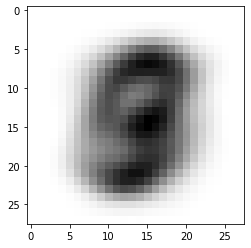

In [9]:
#Visualisation of the MLE estimate
theta_MLE = theta_MLE.reshape(28,28)*255
plt.imshow(theta_MLE, cmap = plt.cm.binary)

# Section 2. Implementing KMeans on MNIST to cluster data

So we have studied KMeans as a very intuitive approach to clustering data. Suppose we want to categorize each image into a specific cluster. How do we do that ? 

## One Example: Performing K-means using sklearn.cluster package

In [27]:
from sklearn.cluster import MiniBatchKMeans
Kmeans = MiniBatchKMeans(n_clusters = 10)
Kmeans.fit(train_set)

nodtype_Kmeans = (Kmeans.labels_).tolist()
Kmeans_cluster = np.array(nodtype_Kmeans)

Kmeans.labels_

array([3, 7, 2, ..., 1, 1, 6], dtype=int32)

In [14]:
def retrieve_info(cluster_labels,train_label):
    reference_labels = {}
    for i in range(len(np.unique(Kmeans.labels_))):
        index = np.where(cluster_labels == i,1,0)
        num = np.bincount(train_label[index==1]).argmax()
        reference_labels[i] = num
    return reference_labels

reference_labels = retrieve_info(Kmeans.labels_,train_label)
number_labels = np.random.rand(len(Kmeans.labels_))
for i in range(len(Kmeans.labels_)):
    number_labels[i] = reference_labels[Kmeans.labels_[i]]

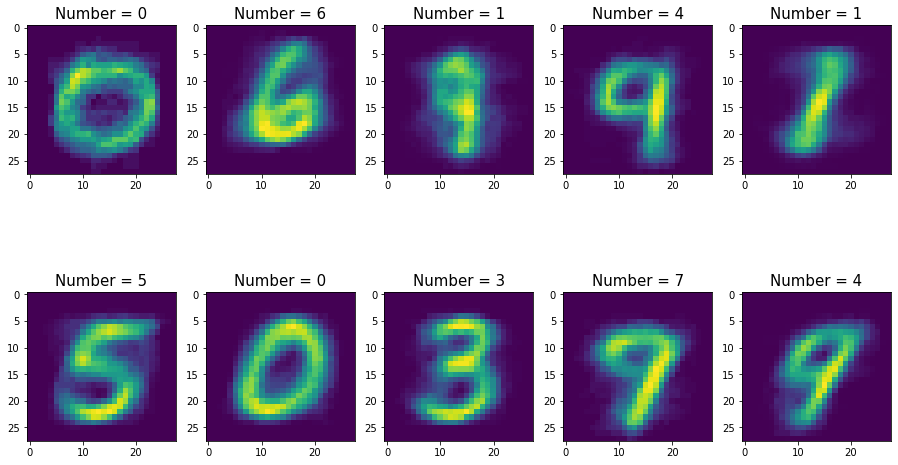

In [15]:
# Visualization for central centroids
centroids = Kmeans.cluster_centers_
centroids.shape
centroids = centroids.reshape(10,28,28)
centroids = centroids * 9

plt.figure(figsize = (15,9))
bottom = 0.1
for i in range(10):
    plt.subplots_adjust(bottom)
    plt.subplot(2,5,i+1)
    plt.title('Number = {}'.format(reference_labels[i]),fontsize = 15)
    plt.imshow(centroids[i])

## Second Example: Seperating Kmeans Components

In [34]:
def calcSqDistances(X, Kmus):
    return ((-2 * X.dot(Kmus.T) + np.sum(np.multiply(Kmus,Kmus), axis=1).T).T + np.sum(np.multiply(X,X), axis=1)).T

In [35]:
def determineRnk(sqDmat):
    m = np.argmin(sqDmat, axis=1)
    return np.eye(sqDmat.shape[1])[m]

In [36]:
# Find the mean of data points in X that belong to a particular cluster. Rnk is a matrix with values pertaining to k clusters
# (Ex. 0-9 for 10 clusters). 
def recalcMus(X, Rnk):
    return (np.divide(X.T.dot(Rnk), np.sum(Rnk, axis=0))).T

In [42]:
def runKMeans(K):
    X = train_set
    N = np.shape(X)[0]
    D = np.shape(X)[1]
    Kmus = np.zeros((K, D))
    rndinds = np.random.permutation(N)
    Kmus = X[rndinds[:K]];
    maxiters = 1000;

    for iter in range(maxiters):
        sqDmat = calcSqDistances(X, Kmus);
        Rnk = determineRnk(sqDmat)
        KmusOld = Kmus
        plt.show()
        Kmus = recalcMus(X, Rnk)
        if sum(abs(KmusOld.flatten() - Kmus.flatten())) < 1e-6:
            break
            
    return Kmus

In [43]:
Kmus_10 = runKMeans(10)
Kmus_20 = runKMeans(20)

# We can see which cluster roughly represents which digit. 

In [44]:
def get_cluster_plot(Kmus): 
    '''
    : get a plot of what different clusters represent
    : takes as input the cluster location matrix
    '''
    fig,axs = plt.subplots(2,5, figsize = (15,9))
    for i in range(len(Kmus)):
        cluster = Kmus[i].reshape(28,-1) * 255
        axs[i//5][i%5].imshow(cluster, cmap = plt.cm.binary)
        axs[i//5][i%5].set_title(f'Cluster {i + 1}')

IndexError: index 2 is out of bounds for axis 0 with size 2

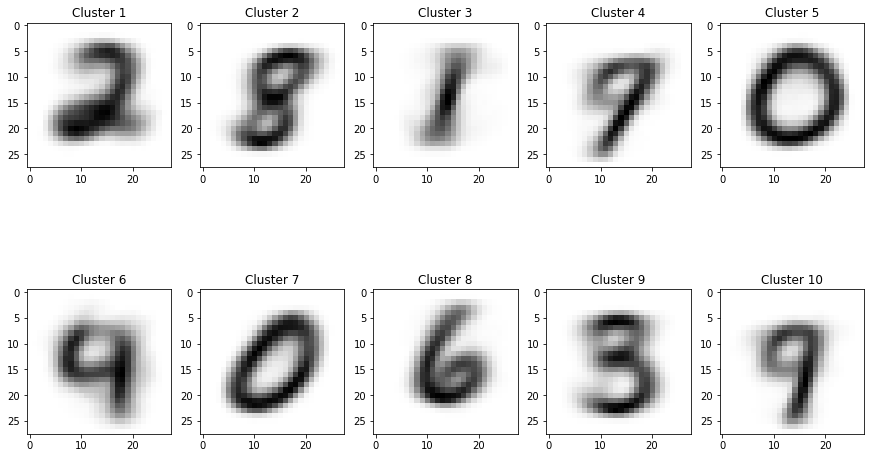

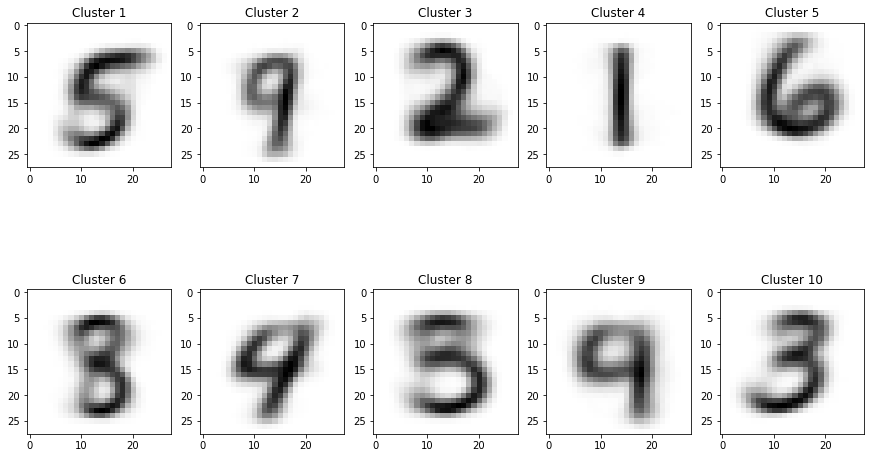

In [45]:
get_cluster_plot(Kmus_10) #Get cluster representation for K = 10 clusters
get_cluster_plot(Kmus_20) #Get cluster representation for K = 20 clusters

## Can you think of a way to get cluster accuracies and determine given a new image, which cluster it belongs to and hence which number it represents ? (BONUS)

### Given the cluster outputs from KMeans, which cluster represents which digit. 

In [46]:
def cluster_assignments(Kmus):
    '''
    : Given the locations of the clusters and the training data, assign which digit each cluster represents
    '''
    assert isinstance(Kmus, np.ndarray)
    x_train = train_set
    y_train = train_label
    dist = calcSqDistances(x_train, Kmus)
    responsibility = determineRnk(dist)
    cluster_dict = dict()
    for i in range(len(Kmus)): 
        '''
        : Get the digits corresponding to each cluster
        : For each cluster, count the number of times each digit in train set has a 1.
        : Assign cluster the digit that has maximum number of 1's
        '''
        cluster_members = responsibility[:,i]
        digits = y_train[cluster_members == 1]
        cluster_digit = np.bincount(digits).argmax()
        cluster_dict.update({i + 1: cluster_digit})
    return cluster_dict

### Given now the clusters and what digits these clusters represent, we want to find which cluster a new digit will belong to and hence what number it is. 

In [48]:
# Implement
def determine_cluster(x,Kmus):
    dist = []
    Kmus = cluster_assignments(Kmus)
    for i in range(len(Kmus)):
        point_distance = calcSqDistances(x, Kmus[i])
        dist = dist.append(point_distance)
        responsibility = determineRnk(dist)
        if responsibility[i] == 1:
            return i
        break
    '''
    : Given a data point x and location of the clusters, find out which cluster data belongs to
    '''
    assert isinstance(x , np.ndarray) and isinstance(Kmus, np.ndarray) and x.shape[-1] == Kmus.shape[-1]
    

In [ ]:
# Implement
def determine_cluster(x,Kmus):
    
    '''
    : Given a data point x and location of the clusters, find out which cluster data belongs to
    '''
    assert isinstance(x , np.ndarray) and isinstance(Kmus, np.ndarray) and x.shape[-1] == Kmus.shape[-1]
    
    dist = calcSqDistances(x, Kmus)
    cluster = np.argmin(dist)
    
        # Get the cluster assignments
    cluster_dict = cluster_assignments(Kmus)

        # Determine which cluster the new digit belongs to
    cluster = determine_cluster(new_digit, Kmus)

        # Get the digit that the cluster represents
    digit = cluster_dict[cluster]

    return digit
    

### Now find out what is the accuracy of the KMeans algorithm i.e. how accurately it clusters images to the right digit. Report the accuracies for K = 10,20. 

In [ ]:
# #Implement
# def compute_accuracy(y):
#     '''
#     : Given the predicted labels for data points using KMeans, compare them with true labels
#     '''
    
#     # Get the cluster assignments
#     cluster_dict = cluster_assignments(Kmus)
    
#     # Determine the predicted labels for each data point
#     pred_label = []
#     for x in data:
#         # Determine which cluster the data point belongs to
#         cluster = determine_cluster(x, Kmus)
        
#         # Get the digit that the cluster represents
#         pred_labels = cluster_dict[cluster]
        
#         # Add the predicted label to the list
#         pred_label.append(pred_labels)
    
#     # Calculate the accuracy by comparing the predicted labels with the true labels
#     accuracy = np.mean(pred_labels == y)
    
#     # Return the accuracy
#     return accuracy
    

In [ ]:
def compute_accuracy(y_pred, y_true):
    # Convert y_pred and y_true to numpy arrays
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    
    # Checking if arrays have the same length
    assert y_pred.shape == y_true.shape
    
    # Counting # of matches
    matches = np.sum(y_pred == y_true)
    
    # Compute accuracy
    accuracy = matches / y_pred.shape[0]
    return accuracy

In [ ]:
y_pred = [1, 2, 3, 4, 5, 6]
y_true = [2, 2, 3, 5, 5, 6]


accuracy = compute_accuracy(y_pred, y_true)

print(accuracy)

In [51]:
# Implement
def compute_accuracy(y_true, y_pred):
    '''
    : Given the predicted labels for data points using KMeans, compare them with true labels
    '''

### Implement code to find accuracy for K=10,20 clusters using the code cells above. Report the accuracy in a dictionary with key as the K value and accuracy result as the value of the dictionary.

# 3. Implementation of a Mixture of Bernoulli Distributions

We have seen the performance of a single Bernoulli Distribution on the dataset. We saw it was not very good. On the other hand, using KMeans, we saw that same digits are having different cluster centers based on the writing style. Ex : In the image above, we can see that 0 is associated with clusters 5,7,13 and so on. So we hypothesise that a single digit cannot be entirely sampled from a single distribution and hence a mixture model maybe able to better explain the datas. 

Let us assume that our model is actually a Mixture of Multivariate Bernoulli random variable. For now, let us assume that the model consists of 10 multivariate bernoulli distributions. In this case, given a vector of pixel values, we don't know which cluster it belongs to. So let $z = \{1,2,3,4,5,...,10\}$ represent the cluster numbers. Each cluster is a multivariate bernoulli random variable and hence $$\begin{equation} p(x | z = k) = \prod_{j = 1}^d \theta_{kj}^{x_j} (1 - \theta_{kj})^{1 - x_j}  \\ ∀ k ∈ \{1,2,...,10\} \end{equation} $$ where $p(z = k) = \pi_k$
Using this we write $$p(x,z) = p(x | z = k) p(z = k) = \prod_{k = 1}^{10} (\pi_k p(x | \theta_k))^{z_k} $$ where $z_k = 1$ if the data point belongs to cluster k. This is the one hot encoding trick discussed in class. Now given a dataset $D = \{x_1, x_2, x_3, ...., x_N\}$, the likelihood can be written as $$p(X, Z) = \prod_{i = 1}^N p(x_i, z) = \prod_{i = 1}^N \prod_{k = 1}^{10} (\pi_k p(x_i | \theta_k))^{z_{ik}}$$ This is the total data likelihood that we want to maximize in the presence of unknown/latent variables. Taking the log of this, we have $$log(p(X,Z)) = \sum_{i = 1}^N \sum_{k = 1}^{10} z_{ik} log(p(x_i | z = k) = \sum_{i = 1}^N \sum_{k = 1}^{10} z_{ik} (log(\pi_k) + \sum_{j = 1}^d (x_{ij}log(\theta_{kj}) + (1 - x_{ij})log(1 - \theta_{kj})))$$ This is the function that we would like to maximise and get the optimal values of $\theta$ and $\pi$. But since the latent variables are unknow, what we do is we take the expectation of this expression wrt observed data $X$ and some initial guess for the parameters that we want to find $\theta$ and $\pi$. The only expression above that depends on the latent variable is $z_{ik}$ and since this is a one hot encoding variable, we know that $$E[z_{ik} | X; \theta^o, \pi^o] = P(z_{ik} = k | X; \theta^o, \pi^o)$$ Applying Bayes Theorem, we have $$P(z_{ik} = k | X; \theta^o, \pi^o) = \frac{P(X | z_{ik} = k;  \theta^o, \pi^o) P(z_{ik} = k)}{\sum_{k = 1}^{10} P(X | z_{ik} = k;  \theta^o, \pi^o) P(z_{ik} = k)}$$ from which we have $$ \gamma_{ik} = \frac{\pi_k^o P(x_i | z = k; \theta_k ^o)}{\sum_{m = 1}^{10} \pi_m^o P(x_i | z = m; \theta_m ^ o)} $$ This is the E step of the EM algorithm. Now we have the expectation of the total data log likelihood as $$Q(\theta, \pi; \theta^o, \pi^o ) = E[log(p(X,Z))] = \sum_{i = 1}^N \sum_{k = 1}^{10} \gamma_{ik} (log(\pi_k) + \sum_{j = 1}^d (x_{ij}log(\theta_{kj}) + (1 - x_{ij})log(1 - \theta_{kj})))$$ Now our aim in the M step is to find optimal parameters $\theta$ and $\pi$ that maximize the Q function $Q(\theta, \pi; \theta^o, \pi^o )$ subject to constraints $\sum_{k = 1}^{10} \pi_k = 1$ The result of the optimisation process is as follows 
$$\pi_k^{o + 1} = \frac{\sum_{i = 1}^N \gamma_{ik}}{N}$$ and $$\theta_k^{o + 1} = \frac{\sum_{i = 1}^N \gamma_{ik} x_{i}}{\sum_{i = 1}^N \gamma_{ik}}$$

Thus, we have arrived at the end of M step. Now we repeat the process untill the change in parameters in negligible. So overall, the EM algorithm for Mixture of Bernoulli can be summarised as follows :- 
1. Start with a guess of parameters $\pi^o$ and $\theta^o$ where $\sum_{k = 1}^{10} \pi^o = 1$. 
2. E step : Compute $\gamma_{ik}$ for $i \in \{1,2,...,N\}$ and $k \in \{1,2,3...,10\}$ 
$$\gamma_{ik} = \frac{\pi_k^o P(x_i | z = k; \theta_k ^o)}{\sum_{m = 1}^{10} \pi_m^o P(x_i | z = m; \theta_m ^ o)} $$
3. M step: Find the next iteration values of parameters $\pi^{o + 1}$ and $\theta^{o + 1}$ $$\pi_k^{o + 1} = \frac{\sum_{i = 1}^N \gamma_{ik}}{N}$$ $$\theta_k^{o + 1} = \frac{\sum_{i = 1}^N \gamma_{ik} x_{i}}{\sum_{i = 1}^N \gamma_{ik}}$$

Using this framework, lets try to build a mixture model for the dataset.

In [ ]:
#Implement
def train_EM_MOB(x , pi, theta, K = 10):
    
    '''
    :input arguments ---> data set, mixture probabilities, initial cluster locations and number of mixtures
    : Implement the EM algorithm for Mixture of Bernoulli random variables
    : HINT -> We strongly recommend to avoid two nested for loops. Try vectorising your code. 
    : A simple example of vectorisation is as follows :- 
    : Assume you have two vectors a and b. Suppose you want to find out the dot product of a and b. 
    : There are two ways -> 1. sum = 0 ; for i in range(len(a)): sum += a[i]*b[i] 
    : 2. sum = a.T @ b
    : The second method uses the matrix properties to get the same result as first. This is the main idea. 
    : Also it is a good idea to try out your own code with a small minibatch of data instead of the full data. 
    '''
    pass


In [ ]:
# #Implement
# def train_EM_MOB(x , pi, theta, K = 10): 
#     '''
#     :input arguments ---> data set, mixture probabilities, initial cluster locations and number of mixtures
#     : Implement the EM algorithm for Mixture of Bernoulli random variables
#     : HINT -> We strongly recommend to avoid two nested for loops. Try vectorising your code. 
#     : A simple example of vectorisation is as follows :- 
#     : Assume you have two vectors a and b. Suppose you want to find out the dot product of a and b. 
#     : There are two ways -> 1. sum = 0 ; for i in range(len(a)): sum += a[i]*b[i] 
#     : 2. sum = a.T @ b
#     : The second method uses the matrix properties to get the same result as first. This is the main idea. 
#     : Also it is a good idea to try out your own code with a small minibatch of data instead of the full data. 
#     '''
#     pass


In [ ]:
# def train_EM_MOB(x, pi, theta, K=10):
#     # Initialize some variables
#     N = len(x) # Number of data points
#     pi = np.array(pi) # Mixture probabilities
#     theta = np.array(theta) # Cluster locations
#     max_iter = 100 # Maximum number of iterations
#     tol = 1e-6 # Tolerance for convergence
    
#     # Loop until convergence or maximum number of iterations is reached
#     for i in range(max_iter):
#         # Compute the probabilities for all data points and mixture components
#         p = (x @ theta.T) * pi
        
#         # Compute the responsibilities for all data points and mixture components
#         r = p / p.sum(axis=1, keepdims=True)
        
#         # Update the estimates of the mixture probabilities and cluster locations
#         pi = r.sum(axis=0) / N
#         theta = (x.T @ r) / r.sum(axis=0)
        
#         # Check for convergence
#         if np.abs(pi - pi_old).max() < tol and np.abs(theta - theta_old).max() < tol:
#             break
    
#     # Return the estimated mixture probabilities and cluster locations
#     return pi, theta

#     pass


In [ ]:
# # Define the EM algorithm for a mixture of Bernoulli random variables
# def train_EM_MOB(x, pi, theta, K=10):
#     # Initialize some variables
#     N = len(x) # Number of data points
#     pi = np.array(pi) # Mixture probabilities
#     theta = np.array(theta) # Cluster locations
#     max_iter = 100 # Maximum number of iterations
#     tol = 1e-6 # Tolerance for convergence
    
#     # Loop until convergence or maximum number of iterations is reached
#     for i in range(max_iter):
#         # Store the previous estimates
#         pi_old = pi
#         theta_old = theta
        
#         # Compute the probabilities for all data points and mixture components
#         # Reshape the input data and cluster locations to have compatible dimensions
#         p = np.dot(x.reshape(N, -1), theta.T) * pi
        
#         # Compute the responsibilities for all data points and mixture components
#         r = p / p.sum(axis=1, keepdims=True)
        
#         # Update the estimates of the mixture probabilities and cluster locations
#         pi = r.sum(axis=0) / N
#         theta = (x.T @ r) / r.sum(axis=0)
        
#         # Check for convergence
#         if np.abs(pi - pi_old).max() < tol and np.abs(theta - theta_old).max() < tol:
#             break
    
#     # Return the estimated mixture probabilities and cluster locations
#     return pi, theta

# # Load the training set
# train = train_set

# # Set the initial values for the mixture probabilities and cluster locations
# pi = [0.25, 0.25, 0.25, 0.25]
# theta = [[0.1, 0.2, 0.3, 0.4],
#          [0.4, 0.3, 0.2, 0.1],
#          [0.2, 0.4, 0.1, 0.3],
#          [0.3, 0.1, 0.4, 0.2]]

# # First try out with a small dataset
# pi_new, theta_new = train_EM_MOB(train[:500] , pi , theta)

# # After ensuring it works as expected, run on full dataset
# pi_new, theta_new = train_EM_MOB(train , pi, theta)


In [ ]:
def train_EM_MOB(x, pi, theta, K = 10):
    # E-step
    # Compute the posterior probabilities of the latent variables
    # given the observed data and the current estimates of the model parameters
    gamma = pi * theta**x * (1 - theta)**(1 - x)
    gamma /= np.sum(gamma, axis=1, keepdims=True)
    
    # M-step
    # Update the estimates of the model parameters
    # using the expected values of the latent variables
    pi = np.mean(gamma, axis=0)
    theta = np.sum(gamma * x, axis=0) / np.sum(gamma, axis=0)

        # Initialize the mixture probabilities and the cluster locations
    pi = np.ones(K) / K
    theta = np.random.random((K, x.shape[1]))

    # Iteratively apply the EM algorithm
    for i in range(max_iter):
        pi, theta = train_EM_MOB(x, pi, theta, K)
        
    # Compute the log likelihood
    log_likelihood = np.sum(np.log(np.sum(pi * theta ** x * (1 - theta) ** (1 - x), axis=1)))

    return pi, theta


In [ ]:
# train = train_set
# #Initialise the P(z = k) = $$\pi_k$$
# pi = 
# #Initialise theta
# theta =
# #First try out with a small dataset
# pi_new, theta_new = train_EM_MOB(train[:500] , pi , theta)
# #After ensuring it works as expected, run on full dataset
# pi_new, theta_new = train_EM_MOB(train , pi, theta)

In [ ]:
# train = train_set

# #Initialise the P(z = k) = $$\pi_k$$
# pi = np.ones(K) / K

# #Initialise theta
# theta = np.random.uniform(0, 1, (x.shape[0], K))

# #First try out with a small dataset
# pi_new, theta_new, log_likelihood = train_EM_MOB(train[:500] , pi , theta)
# #pi_new, theta_new = train_EM_MOB(train[:500] , pi , theta)


# #After ensuring it works as expected, run on full dataset
# pi_new, theta_new, log_likelihood = train_EM_MOB(train , pi, theta)
# #pi_new, theta_new = train_EM_MOB(train , pi, theta)

In [ ]:
train = train_set

#Initialise the P(z = k) = $$\pi_k$$
pi = np.ones(K) / K

#Initialise theta
theta = np.random.uniform(0, 1, (x.shape[0], K))

#First try out with a small dataset
pi_new, theta_new, log_likelihood = train_EM_MOB(train[:500] , pi , theta)
#pi_new, theta_new = train_EM_MOB(train[:500] , pi , theta)


#After ensuring it works as expected, run on full dataset
pi_new, theta_new, log_likelihood = train_EM_MOB(train , pi, theta)
#pi_new, theta_new = train_EM_MOB(train , pi, theta)

In [ ]:
train = train_set
#Initialise the P(z = k) = $$\pi_k$$
pi = 
#Initialise theta
theta =
#First try out with a small dataset
pi_new, theta_new = train_EM_MOB(train[:500] , pi , theta)
#After ensuring it works as expected, run on full dataset
pi_new, theta_new = train_EM_MOB(train , pi, theta)

In [ ]:
#Visualise the 10 clusters that you obtained
get_cluster_plot(theta_new) #Get the cluster representation for a mixture model with 10 mixtures

## Implement something on your own beyond this point. Contact Professor for ideas about what can be done further. 